In this code, our objective is to train some classic models such as SVM, KNN, RandomForest, etc on our test data, and try to evaluate their efficiency by plotting confusion matrixes, learning curves, validation curves, and measuring the prediction time. 

Import required libreries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import phase I data

In [ ]:
# phase I data which is entirely cleared and preprocessed should be imported here.
# we will have X,Y variables which are representations for sample data with their features 
# and the target function which is Y

In [58]:
# X,Y = # is a table consisting samples with their features: X concat Y (with the name Y)
# tst_size = 0.2
# ns, nf = np.shape(X) 
# X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )

SyntaxError: invalid syntax (Temp/ipykernel_10764/4245754019.py, line 1)

In [ ]:
# this is fake data, only for debugging purpose

huge_data =  pd.read_csv('sample_data.csv')
print(huge_data.head())
narrower_data= huge_data.drop(['Unnamed: 0','phkey','In_halo_log'], axis=1)
narrower_data.head()
data = np.array(narrower_data)
X = data[:,2:8]
X = np.concatenate((X,X))
# print(x.shape)
Y = data[:,9]
Y = np.concatenate((Y,Y))
# print(y.shape)

(60,)


# SVM Model

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

svc = svm.SVC()
tst_size = 0.2
ns, nf = np.shape(X) 
# split data to train and test 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
# cross validation
scores = cross_val_score(svc, X_train, Y_train, cv=5 ,scoring= 'f1')
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
# evaluate hyper-parameters 
clf = GridSearchCV(svc, param_grid)
# train model
trained_model = clf.fit(X_train, Y_train)
# predict data
Y_pred = trained_model.predict(X_test)

C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 26

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}


C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


-----------------
[ 0.  0. 24. 24. 24. 24. 40.  0. 24. 40.  2. 40. 24.  0. 24. 24. 24. 24.
 24. 24.  0. 24. 40. 24. 24.  0. 40.  0.  0.  0.]


### Classification Report
Print some information about the trained model such as training time, ... 

In [ ]:
print("Best parameters set found on development set:")
print()
print(trained_model.best_params_)
sorted(trained_model.cv_results_.keys())

print('-----------------')
print(Y_pred)
from sklearn.metrics import classification_report


### Confusion Matrix

C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1647: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 3 instead of 4.
  warnings.warn(
C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection

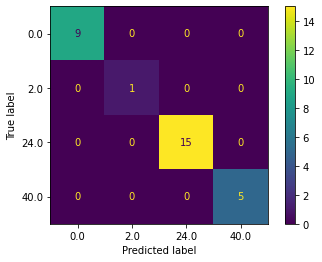

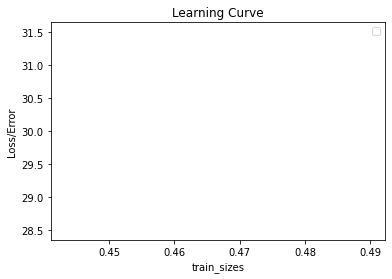

NameError: name 'Ridge' is not defined

In [50]:
confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(trained_model, X_test, Y_test)

### Learning Curve


C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Kanoa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: Unrecognized character u in format string

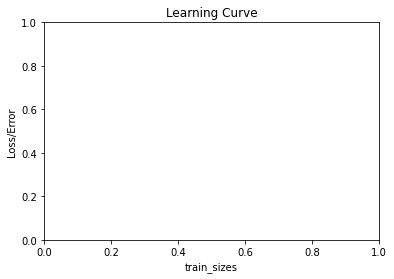

In [56]:
ns = [0.1,0.5,0.7]
train_sizes, train_scores, valid_scores = learning_curve(clf, X, Y, train_sizes=ns, cv=2)
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='train_sizes', ylabel='Loss/Error', title='Learning Curve')

plt.plot(valid_scores,train_sizes, 'out_sample')
plt.plot(train_scores, train_sizes, 'in_sample')

plt.legend()
# plt.yscale('log')
plt.show()

### Validation Curve


In [ ]:
from sklearn.linear_model import Ridge
#validation_curve:
train_scores, valid_scores = validation_curve(Ridge(), x, y, param_name="alpha", param_range=np.logspace(-7, 3, 3),cv=5)
ax = fig.add_subplot(111, xlabel='train_sizes', ylabel='Loss/Error', title='Validation Curve')

plt.plot(valid_scores,train_sizes, 'x' )
plt.plot(train_scores, train_sizes, 'y')

plt.legend()
# plt.yscale('log')
plt.show()


### Regularization (if needed) 
do we need it??

from sklearn.linear_model import Ridge
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


# deg_list 
deg = 15
ns = 20
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X_bbr, Y_bbr, n_samples = ns, random_state=0) , random_state=0, test_size =.5 )


w_list = []

x_range = np.arange(X_bbr.min(), X_bbr.max(), .1)


fig = plt.figure()
ax = fig.add_subplot(111, xlabel=x_label, ylabel=y_label, title=plt_title)
# ax.scatter(X_train, Y_train, label = 'Train data')
ax.scatter(X_test, Y_test, c='black', label = 'Test data')


r_list = [0,.1,1,10]

for r in r_list:

  rg = Pipeline([('poly', PolynomialFeatures(degree=deg) ), 
                ('model', Ridge( alpha=r ) ### We are using Ridge which uses l2 regularization. 
                )])
  rg.fit( X_train.reshape(-1,1), Y_train )

  ### Let's store the weights
  w_list += [rg[1].coef_]

  y_range = rg.predict(x_range.reshape(-1,1) )
  ax.plot(x_range, y_range,  alpha = .6, label=f'Regularization={r}')


w_list = np.array(w_list)
plt.ylim(-1.5,2)
ax.legend()
plt.show()

# classification
this is Raeisi's code for classification purpose

from sklearn.model_selection import learning_curve, validation_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

ns_list = np.array([ 3, 5, 10, 20 , 30 , 50, 76, 200])
ncv = 5
## Here's how you can use the function implemented in sklearn for this. 
## But note that this works with scores instead of loss. 

ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator = SVC( ), 
                                                   X = X_train_prt, y = Y_train_prt, 
                                                   train_sizes = ns_list, 
                                                   cv = ncv,
                                                   scoring = 'accuracy', 
                                                   n_jobs= -1
                                                   )
                                                   train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  validation_scores.mean(axis = 1)
validation_scores_std  = validation_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = 'Accuracy'

plt_title = 'Learning Curve'

fig = plt.figure()
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(ns_list, train_scores_mean, label = 'Training Score')
ax.plot(ns_list, validation_scores_mean, label = 'Validation Score')

plt.fill_between(ns_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(ns_list, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)


ax.legend(loc=0)
plt.show()